In [1]:
import pystan as ps
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


# used to force examples to run from local copy, rather than installed copy
import os, sys; sys.path.insert(0, os.path.abspath('../'))
import btom as bt

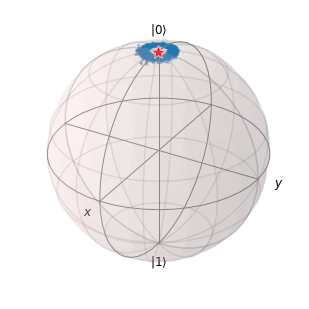

In [42]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=1)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData(meas_ops, [100,100,1000], [50,50,995])
pos = bt.StatePosterior(sampler, data)
pos.bloch_plot()

In [3]:
def _set_labels(ax, labels, d='x'):
    if d == 'x':
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
    elif d == 'y':
        ax.get_yaxis().set_tick_params(direction='out')
        ax.yaxis.set_ticks_position('bottom')
        ax.set_yticks(np.arange(1, len(labels) + 1))
        ax.set_yticklabels(labels)
        ax.set_ylim(0.25, len(labels) + 0.75)

In [13]:
arg

array([ 0.        ,  1.57079633,  1.57079633, -0.78539816])

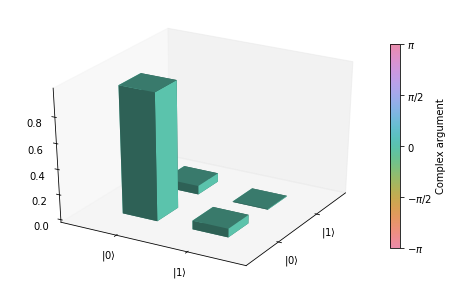

In [43]:
b = bt.canonical_basis(2)
bm = b.outer_product()
#pos._samples = np.array([[[1, 1j],[0.5 * 1j, 4 * np.exp(1j * np.pi)]]])
coeffs = bm.expansion(pos.states)
coeffs.shape

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as col
import matplotlib as mpl

# setup the figure and axes
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111, projection='3d')

# fake data
x = np.tile(np.arange(b.n_arrays),b.n_arrays) + 0.75
y = (np.arange(b.n_arrays)).repeat(b.n_arrays) + 0.75

top = np.mean(np.abs(coeffs), axis=1)
arg = np.mean(np.angle(coeffs), axis=1)
colors = bt.utils.complex_cmap(0.5 * (arg + np.pi) / np.pi)
bottom = np.zeros_like(top)
width = depth = 1


ax1.bar3d(x, y, bottom, 0.5, 0.5, top, shade=True, color=colors)

zaxis = ax1.zaxis
#draw_grid_old = zaxis.axes._draw_grid
# disable draw grid
zaxis.axes._draw_grid = False

tmp_planes = zaxis._PLANES

# draw zaxis on the left side
zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                 tmp_planes[0], tmp_planes[1],
                 tmp_planes[4], tmp_planes[5])

#olourMap = plt.cm.ScalarMappable(cmap=bt.utils.complex_cmap, norm=col.Normalize(-np.pi, np.pi))
#olourMap.set_array(arg)
#olBar = plt.colorbar(colourMap, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi]).set_label('Argument')
#colBar.set_labels((r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'))
cax, kw = mpl.colorbar.make_axes(ax1, shrink=.75, pad=.0)
cb = mpl.colorbar.ColorbarBase(cax, cmap=bt.utils.complex_cmap, norm=col.Normalize(-np.pi, np.pi), label='Complex argument')
cb.set_ticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
cb.set_ticklabels((r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'))


_set_labels(ax1, ['$' + name + '$' for name in b.names], 'x')
_set_labels(ax1, ['$' + name + '$' for name in b.names], 'y')

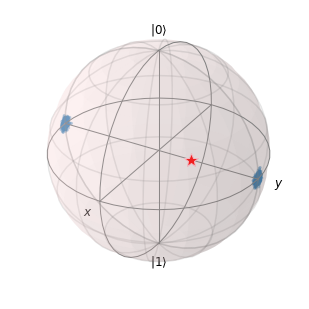

In [3]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=1)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData(meas_ops, [1000,0,1000], [500,0,500])
pos = bt.StatePosterior(sampler, data)
a = pos.bloch_plot()

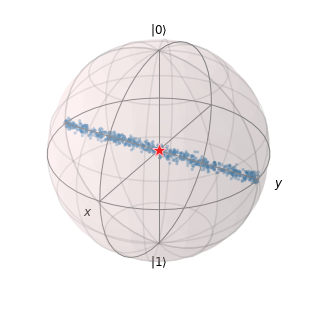

In [5]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=2)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData(meas_ops, [5000,0,1000], [2500,0,500])
pos = bt.StatePosterior(sampler, data)
a = pos.bloch_plot()